In [5]:
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import os
from pathlib import Path
from random import random
from shapely.geometry import Polygon
from shapely.ops import unary_union
import networkx as nx

DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'

In [7]:
#alpha shape / concave hull
from shapely.ops import cascaded_union, polygonize,  Point,Polygon
import shapely.geometry as geometry
from scipy.spatial import Delaunay
import numpy as np
import math
def concave_hull(boundary_points, alpha):
    #Draws the minimal concave polygon with a concavity  factor alpha 
    if len(boundary_points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(boundary_points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        #adds a line between points i and j
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in boundary_points])

    #Minimal set of triangles with points in set
    tri = Delaunay(coords)

    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return unary_union(triangles), edge_points

In [8]:
#Read_file_names
def read_file_names():
    os.chdir(''.join([DIR,'input']))
    fullPath = Path(''.join([DIR,'input']))
    paths = sorted(fullPath.iterdir(),key=os.path.getmtime)
    fileNames = [f.name for f in paths if  f.suffix == '.csv' ]
    print(fileNames)
    return fileNames

In [2]:
#CC class
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import logging
import os
from pathlib import Path
from random import random
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import networkx as nx
import calendar
import time
import copy

current_GMT = time.gmtime()
time_stamp = str(calendar.timegm(current_GMT))

NAME = "Cylinder"
DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'
logging.basicConfig(filename=''.join(['log_',str(time_stamp)])  , filemode='w', level=logging.DEBUG)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))
log = logging.getLogger("my-logger")
#suggested libraries 
#import pytest as pt
#import logging as log # replace writes to the console with various logging 
class CylinderCollection:
    
    #initialize our object level variables for cylider objects 
    def __init__(self, filename) -> None:
        self._fileName = filename
        self._x = np.nan
        self._y = np.nan
        self._z = np.nan
        self._radius = np.nan
        self._noCylinders = np.nan
        self._cLength = np.nan
        self._BO = np.nan
        self._branchID = np.nan
        self._angles = np.nan
        self._surface_area = np.nan
        self._volume = np.nan
        self._dx = np.nan
        self._dy = np.nan
        self._dz = np.nan
        self._pID = np.nan
        self._trunkLean = np.nan
        self._pSV = []
        self._pSVXY = []
        self._df = pd.DataFrame()
        self._stemPathLengths = []
        self._graph = nx.Graph()
        self._diGraph=  nx.Graph()
        self._bID = np.nan
        self._dripPoints = []
        self._projection =None
        self._aV=pd.DataFrame()
        self._bV=pd.DataFrame()
        self._stemPaths=pd.DataFrame()
        self._flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as','vol','saTovol']) 
        self._flowToDrip = {0:1} # A dictionary of flow ids with values equal to their drip node ids 
        self._trunkNodes = []
        self._dripLoc = np.nan
        self._treeQualities  = pd.DataFrame({'total_psa':-1 ,
                                            'tot_hull_area':-1, 
                                            'stem_flow_hull_area':-1 ,
                                            'stem_psa':-1 ,
                                            'flowStats':-1 ,
                                            'DBH':-1,
                                            'tot_surface_area':-1,
                                            'stem_surface_area':-1
                                            },index=[0])
        self._stemTotal = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0,'vol':0,'saTovol':0}, index = [0])
        self._dripTotal = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0,'vol':0,'saTovol':0}, index = [0])
        self._flowAgg = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0,'vol':0, 'saTovol':0, 'type':''}, index = [0])
        self._divideIds = []
        self._stemPolys = []
        self._compGraphs = []
        self._stemFlowComponent = nx.Graph()
        self._dripFlowComponents = []
        self._flowChars = {}

    
    def saveFile(self, toWrite = [], subdir:str = 'agg', fileFormat ='.png',method=''):
        proj = self._projection
        file_arr = os.path.splitext(os.path.basename(self._fileName))
        dir = '/'.join([self._output_dir, method, '']).replace('/','\\')
        ofname = '_'.join([file_arr[0], method, proj , fileFormat ]).replace('/','\\')
        aggname = '_'.join(['agg', method, proj , fileFormat ]).replace('/','\\')
        folderExists = os.path.exists(dir)
        fileExists = os.path.exists(dir+ofname)
        aggExists = os.path.exists(dir+aggname)
        if not folderExists:
            os.makedirs(dir)
        if fileFormat =='.png': 
            plt.savefig(dir+ofname, format='png', dpi=1200)
        else:
            if not fileExists:
                with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)
            else:
                exist = pd.read_excel(open(dir+ofname, 'rb'), sheet_name=method, engine = 'openpyxl')  
                toWrite = toWrite.append(exist)
                with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)
            if not aggExists:
                with pd.ExcelWriter(dir + aggname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)    
            else:
                exist = pd.read_excel(open(dir+aggname, 'rb'), sheet_name=method, engine = 'openpyxl')  
                toWrite = toWrite.append(exist)
                with pd.ExcelWriter(dir + aggname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)
    
    def readCsv(self,df = pd.DataFrame(), polys = [],projection='XY'):
        self._projection =projection 
        self._df = pd.readCsv(self._fileName,header=0)
        #columns 3 and 6 represent our x values
        if projection == 'XZ':
            self._x = np.transpose(self._df.iloc[:,[3,6]].to_numpy())
            self._y = np.transpose(self._df.iloc[:,[5,8]].to_numpy())
            self._z = np.transpose(self._df.iloc[:,[4,7]].to_numpy())
        elif projection == 'YZ':
            self._x = np.transpose(self._df.iloc[:,[4,7]].to_numpy())
            self._y = np.transpose(self._df.iloc[:,[5,8]].to_numpy())
            self._z = np.transpose(self._df.iloc[:,[3,6]].to_numpy())    
        else: # 'XY'
            self._x = np.transpose(self._df.iloc[:,[3,6]].to_numpy())   
            self._y = np.transpose(self._df.iloc[:,[4,7]].to_numpy()) 
            self._z = np.transpose(self._df.iloc[:,[5,8]].to_numpy()) 
        # for side view
        self._pID =self._df.iloc[:,2].to_numpy()
        self._radius = self._df.iloc[:,9].to_numpy()
        self._noCylinders = self._radius.size
        self._cLength = self._df.iloc[:,12].to_numpy()
        self._BO = self._df.iloc[:,20].to_numpy()
        self._branchID = self._df.iloc[:,4].to_numpy()
        self._bID = self._df.iloc[:,24].to_numpy()
        if projection == 'XZ':
            self._dx = self._df.iloc[:,6].to_numpy() - self._df.iloc[:,3].to_numpy()
            self._dy = self._df.iloc[:,8].to_numpy() - self._df.iloc[:,5].to_numpy()
            self._dz = self._df.iloc[:,7].to_numpy() - self._df.iloc[:,4].to_numpy()
            self._trunkLean = np.arctan(np.sum(self._dy[np.where(self._BO == 0)[0]])/np.sqrt(np.sum(self._dx[np.where(self._BO == 0)[0]])**2 + np.sum(self._dz[np.where(self._BO == 0)[0]])**2))
        elif projection == 'YZ':
            self._dx = self._df.iloc[:,8].to_numpy() - self._df.iloc[:,5].to_numpy()
            self._dy = self._df.iloc[:,7].to_numpy() - self._df.iloc[:,4].to_numpy()
            self._dz = self._df.iloc[:,6].to_numpy() - self._df.iloc[:,3].to_numpy()
            self._trunkLean = np.arctan(np.sum(self._dx[np.where(self._BO == 0)[0]])/np.sqrt(np.sum(self._dz[np.where(self._BO == 0)[0]])**2 + np.sum(self._dy[np.where(self._BO == 0)[0]])**2))
        else: # 'XY'
            self._dx = self._df.iloc[:,6].to_numpy() - self._df.iloc[:,3].to_numpy()  
            self._dy = self._df.iloc[:,7].to_numpy() - self._df.iloc[:,4].to_numpy()
            self._dz = self._df.iloc[:,8].to_numpy() - self._df.iloc[:,5].to_numpy() 
            self._trunkLean = np.arctan(np.sum(self._dz[np.where(self._BO == 0)[0]])/np.sqrt(np.sum(self._dx[np.where(self._BO == 0)[0]])**2 + np.sum(self._dy[np.where(self._BO == 0)[0]])**2))
        if('partial' in self._fileName): self._pSV = polys
        self._output_dir = ''.join([DIR,'output/'])
        log.info(self._fileName + " initialized")
    
    #its pro-ject not prah-ject
    def projectCylinders(self,forceXY = False):
        log.info(self._fileName + " cylinder projection begun")
        noCirPoints = 360
        
        tCir = np.linspace(0,2*np.pi,noCirPoints) #360 evenly spaced points between 0 - 2pi (radian degrees)

        XOrtho = np.cos(tCir)
        YOrtho = np.sin(tCir)

        if forceXY:
            dx = self._df.iloc[:,6].to_numpy() - self._df.iloc[:,3].to_numpy()  
            dy = self._df.iloc[:,7].to_numpy() - self._df.iloc[:,4].to_numpy()
            dz = self._df.iloc[:,8].to_numpy() - self._df.iloc[:,5].to_numpy() 
            x = np.transpose(self._df.iloc[:,[3,6]].to_numpy())   
            y = np.transpose(self._df.iloc[:,[4,7]].to_numpy()) 
            z = np.transpose(self._df.iloc[:,[5,8]].to_numpy()) 
        else:
            self._pSV=[]
            dx = self._dx
            dy = self._dy
            dz = self._dz
            x = self._x 
            y = self._y
            z = self._z

        #unit vector at base of cylinder, pointing up cylinder axis
        vNorm = (np.sqrt(dx**2+dy**2+dz**2))
        aV = np.hstack((dx[:,None],dy[:,None],dz[:,None]))/vNorm[:,None]
        bV = -aV; #unit vector looking down from top circle (but not translated)
        if not forceXY:
            self._aV = aV
            self._bV = bV
        #function to find orthgonal vectors
        oVz = lambda v,a,b : ((-v[0]*a - v[1]*b)/v[2])

        #initializing min max arrays+
        minZ = np.zeros_like(dz)
        maxZ = np.zeros_like(dz)

        pSV = []

        #for each cylinder
        for idx in range(len(self._df.index)):

            #in the case there's no horizontal movement of the cylinder ends, it's
            #area is a circle.
            if not np.isnan(x[0,idx]):
                if np.logical_and(dx[idx] == 0, dy[idx] == 0):
            
                    pX = x[0,idx] + self._radius[idx]*XOrtho
                    pY = y[0,idx] + self._radius[idx]*YOrtho
                    cPS = Polygon(list(zip(pX,pY)))
                    minZ[idx] = np.min(z[:,idx])
                    maxZ[idx] = np.max(z[:,idx])
                else:
                    #find orthogonal vectors @ endpoints
                    aVp1 = np.hstack((aV[idx,1],-aV[idx,0]))
                    aVp2 = np.hstack((-aV[idx,1],aV[idx,0]))
                    bVp1 = np.hstack((bV[idx,1],-bV[idx,0]))
                    bVp2 = np.hstack((-bV[idx,1],bV[idx,0]))
                
                    aVp1 = aVp1/np.linalg.norm(aVp1)
                    aVp2 = aVp2/np.linalg.norm(aVp2)
                    bVp1 = bVp1/np.linalg.norm(bVp1)
                    bVp2 = bVp2/np.linalg.norm(bVp2)
                
                    #from each endpoint, use radius to find vertices of the rectangle
                    x1 = x[0,idx] + self._radius[idx]*aVp1[0]
                    y1 = y[0,idx] + self._radius[idx]*aVp1[1]
                    x2 = x[0,idx] + self._radius[idx]*aVp2[0]
                    y2 = y[0,idx] + self._radius[idx]*aVp2[1]  
                    x3 = x[1,idx] + self._radius[idx]*bVp1[0]
                    y3 = y[1,idx] + self._radius[idx]*bVp1[1]
                    x4 = x[1,idx] + self._radius[idx]*bVp2[0]
                    y4 = y[1,idx] + self._radius[idx]*bVp2[1]
            
                    #calculate set of orthgonal vectors using lambda function
                    ZOrtho = oVz(aV[idx,:],XOrtho,YOrtho)
                
                    #unit-ify the orthgonal vectors
                    uovd = np.sqrt(XOrtho**2 + YOrtho**2 + ZOrtho**2)
                    uov = np.hstack((XOrtho[:,None],YOrtho[:,None],ZOrtho[:,None]))/uovd[:,None]
            
                    #donot re unit-fy, you only want the horizontal component, not the
                    #renormalized horizontal component
                
                    #using only the X and Y components, find circle coods in plane of
                    #interest
                    xaC = x[0,idx] + uov[:,0]*self._radius[idx]
                    yaC = y[0,idx] + uov[:,1]*self._radius[idx]
                    zaC = z[0,idx] + uov[:,2]*self._radius[idx]
            
                    xbC = x[1,idx] + uov[:,0]*self._radius[idx]
                    ybC = y[1,idx] + uov[:,1]*self._radius[idx]
                    zbC = z[1,idx] + uov[:,2]*self._radius[idx]
            
                    minZ[idx] = np.min(np.vstack((zaC, zbC)))
                    maxZ[idx] = np.max(np.vstack((zaC, zbC)))
                
                    #assymble total package
                    rX = np.vstack((x1, x2, x3, x4))
                    rY = np.vstack((y1, y2, y3, y4))
            
                    #test for circle parts in polygon
                    try:
                        c1 = Polygon(list(zip([0 if math.isnan(x) else x for x in xaC],[0 if math.isnan(y) else y for y in yaC])))
                        bBox = Polygon(list(zip([0 if math.isnan(x) else x for x in rX],[0 if math.isnan(y) else y for y in rY])))
                        c2 = Polygon(list(zip([0 if math.isnan(x) else x for x in xbC],[0 if math.isnan(y) else y for y in ybC])))
                                 
                        partsPS = [c1,bBox,c2]
                    except:
                        print(idx)
                        # print(list(zip(xaC,yaC)))
                        # print(list(zip(xbC,ybC)))
                
                    try: 
                        cPS = unary_union(partsPS)
                    except:
                        print(np.any(np.isnan(xaC)))
                        # print(yaC)
                        # print(rX)
                        # print(rY)
                        # print(xbC)
                        # print(ybC)
                #cPS = cPS.simplify(0.02,preserve_topology=False)               
                pSV.append(cPS) #save polygons
                            
                #print a progress update once every 10 thousand or so cylinders
                if np.random.uniform(0,1,1) < 0.0001:
                    log.info(self._fileName + ': completed projection of cyl {} \n'.format(np.round((idx/self._noCylinders)*100,decimals=1)))
                    print('completed cyl projection {} \n'.format(np.round((idx/self._noCylinders)*100,decimals=1)))
            if self._projection == 'XY':
                self._pSVXY =pSV
                self._pSV =pSV
            if forceXY:
                self._pSVXY =pSV
            else:
                self._pSV=pSV
    
    def createGraph(self):
        self._projectCylinders(forceXY = True)
        R = {}
        sid = self._df[' ID']
        pid = self._df[' parentID']
        sid.min()

        #QSM's are projected in different directions by swapping x,y and z values
        #however, for out edge calcualtions we need the typical orientation
        if self._projection == 'XZ':
            hypo= self._dy
            a_leg = self._dx
            b_leg = self._dz
        elif self._projection == 'YZ':
            hypo= self._dx
            a_leg = self._dy
            b_leg = self._dz
        else: # 'XY'
            hypo= self._dz
            a_leg = self._dy
            b_leg = self._dx
        
        attr = []
        gr = nx.Graph()
        dg = nx.DiGraph()
        for idx,curr_cyl_data in self._df.iterrows():
            #print a progress update once every 10 thousand or so cylinders
            # if np.random.uniform(0,1,1) < 0.0001:
            #     log.info(self._fileName + ':  wdgraph - adding edge  {} \n'.format(np.round((idx/len(self._df[0]))*100,decimals=1)))
            #     print('wdgraph - adding edges completed {} \n'.format(np.round((idx/len(self._df[0]))*100,decimals=1)))

            # Our first cylinder has ID 0 and parentID -1. 
            # As a result cyilinder 0 is represented by and edge from node 0 to 1, and so on
            child_node = sid[idx] + 1
            par_node = pid[idx] + 1
            curr_cyl_id = idx
            par_cyl_id = np.where(sid == pid[idx])

            len_idx = curr_cyl_data[12]
            radius_idx = curr_cyl_data[9]
            poly_idx = self._pSVXY[curr_cyl_id]
            vector_idx = self._aV[curr_cyl_id]

            
            run = math.sqrt( a_leg[curr_cyl_id]**2 + b_leg[curr_cyl_id]**2)
            rise = hypo[curr_cyl_id]
            if run==0:
                slope_idx = 1 # straightDown e.g. is in flow 
            else:
                slope_idx = rise/run
            
            sa_idx = 2*np.pi*radius_idx*(radius_idx +len_idx) - 2*np.pi*radius_idx*radius_idx
            pa_idx = poly_idx.area
            vol_idx = 2*np.pi*len_idx*radius_idx*radius_idx
            sa_to_vol_idx = sa_idx/vol_idx
            ang_idx = np.arctan(slope_idx)
            bo_idx = curr_cyl_data[20]

            gr.add_edge(child_node,par_node,length = len_idx,
                                radius =radius_idx,
                                aV = vector_idx,
                                poly = poly_idx,
                                inFlowGrade = slope_idx,
                                pa = pa_idx,
                                sa = sa_idx,
                                ang = ang_idx,
                                vol = vol_idx ,
                                sa_to_vol = sa_to_vol_idx,
                                bo = bo_idx
                            )  
            if slope_idx<(0-(1/6)):
                dg.add_edge(child_node,par_node,length = len_idx,
                                radius = radius_idx,
                                aV = vector_idx,
                                poly = poly_idx,
                                inFlowGrade = slope_idx,
                                pa = pa_idx,
                                sa = sa_idx,
                                ang = ang_idx,
                                vol = vol_idx ,
                                sa_to_vol = sa_to_vol_idx,
                                bo = bo_idx
                            )  
            else:
                dg.add_edge(par_node,child_node,length = len_idx,
                                radius = radius_idx,
                                aV = vector_idx,
                                poly = poly_idx,
                                inFlowGrade = slope_idx,
                                pa = pa_idx,
                                sa = sa_idx,
                                ang = ang_idx,
                                vol = ang_idx ,
                                sa_to_vol = sa_to_vol_idx,
                                bo = bo_idx
                            )
        self._graph = gr
        self._diGraph = dg

    def highlightBranchOrder(self, bo):
        trunk_ids = []
        colors = ['']*len(self._pSV)
        rev_polys =['']*len(self._pSV)
        for idx, bo_i in enumerate(self._BO):
            if np.random.uniform(0,1,1) < 0.0001:
                log.info(self._fileName + ': completed coloring BO {} \n'.format(np.round((idx/self._noCylinders)*100,decimals=1)))
                print('completed coloring BO {} \n'.format(np.round((idx/self._noCylinders)*100,decimals=1)))
            if bo_i == bo: 
                trunk_ids.append(idx)
                colors[-idx] = 'Red'
            else:
                colors[-idx] ='None'
            rev_polys[-idx] = self._pSV[idx]

        fig, ax = plt.subplots() 
        myPolys = geo.GeoSeries(rev_polys)
        myPolys.plot(color=colors,ax=ax, alpha = .5)
        self._saveFile(method = 'BO_highlight' )    
        plt.ion()
        plt.show() 
        plt.close()        
    
    def findFlows(self, inFlowGradeLim = -1/6, severeAngleLim=6.3,filt=[] ):#severeAngleLim defaults to >2pi, 
        c= self
        g = c.graph
        if filt ==[]:
            gfilt =copy.deepcopy(g)  
            trunkNodes =  np.where(self._BO == 0)[0] +1 #node_id is cyl_id +1 as cyl 0 has parent -1 
            self._trunkNodes =trunkNodes
        else:
            gfilt = copy.deepcopy(nx.induced_subgraph(g,filt))
            trunkNodes =  np.intersect1d(np.where(self._BO == 0 )[0],filt)  +1#node_id is cyl_id +1 as cyl 0 has parent -1 
            
        gtest = nx.Graph(copy.deepcopy(gfilt))
        self._trunkNodes=trunkNodes 
        gtest = copy.deepcopy(gfilt)
        inFlowDef = 'inFlowGrade'
        #Set attributes used to mark drip point and flows
        nx.set_edge_attributes(g, np.nan, 'flowType') 
        nx.set_edge_attributes(g, np.nan, 'flowID')
        nx.set_edge_attributes(g, np.nan, 'dripNode')
        nx.set_node_attributes(g, np.nan, 'flowType')
        nx.set_node_attributes(g, np.nan, 'isDripPoint')
        nx.set_node_attributes(g, np.nan, 'isDividePoint')
        #function to get angles of unit vectors 
        get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])  
        flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as','vol','saTovol']) 
        trunk_flow = pd.DataFrame({ 'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                    ,'vol' : 0
                                    ,'saTovol' : 0
                                }, index = [0])
        prev_node = None
        trunk_edges = []
        for n in trunkNodes:
            if prev_node !=None:
                trunk_edges.append((prev_node,n))
                g.nodes[n]['flowType'] = 'stem'
            else:
                trunk_edges.append((1,0))
                g.nodes[0]['flowType'] = 'stem' 
            prev_node = n
        for te in trunk_edges:
            g.edges[te]['flowID'] = 0
            g.edges[te]['flowType'] = 'stem' 
        #instead of this we could just remove the trunk edges then .join the remaining comps
        #This creates a common node (a unique 'trunk' node ) neighboring them
        non_trunk_edges = [e for e in gfilt.edges(trunkNodes) if e not in trunk_edges]
        flows = pd.concat([flows, trunk_flow], ignore_index=True)
        gtest.remove_nodes_from(trunkNodes)
        gtest.add_edges_from(non_trunk_edges) 
        #print(nx.number_connected_components(gtest))
        titans = [node for node in gtest.nodes if (nx.degree(gfilt,node)!=nx.degree(gtest,node))]
            #Nodes with a parent node in trunk, only 1 per connected component
        c.connComps = nx.connected_components(gtest)
        compGraphs = [g.subgraph(comp).copy() for comp in self._connComps]
        self._compGraphs =compGraphs
        flow_to_drip = { 0:(1,'stem') }# flow_path_id:(node_id,flow_type); the flow on the trunk is always flow_path_id 0 and has drip point node 1
        for comp_id,compGraph in enumerate(compGraphs): 
            if np.random.uniform(0,1,1) < 0.1:
                log.info(self._fileName + ': flows  {} \n'.format(np.round((comp_id/len(compGraphs))*100,decimals=1)))
                print('completed flows {} \n'.format(np.round((comp_id/len(compGraphs))*100,decimals=1)))
            test = False
            if test : print('comp_id: '+str(comp_id))

            nodes = compGraph.nodes()

            endnodes = [e for e in compGraph.nodes if compGraph.degree(e)==1]
            root =list(set(titans) & set(compGraph.nodes)) #get root of connected component
            if root[0] in endnodes: endnodes.remove(root[0])
            sp = nx.shortest_path(compGraph,target=root[0])
            sp_endNode_paths = [path for path in sp.values() if path[0] in endnodes]
            # stem flow is always id 0
            # print('stem flow added :' + str(flows))
            #arrays we are using are all unit arrays and we want angles with x,y and z ([1,0,0],[0,1,0] and [0,0,1])
            # display(flows)
            for path in sp_endNode_paths:
                # print('path ' + str( path))
                traversedEdges = []
                flow = pd.DataFrame({'cyls' : 0
                                        ,'len' : 0
                                        ,'sa' : 0
                                        ,'pa' : 0
                                        ,'esa': 0
                                        ,'as' : 0
                                        ,'vol': 0
                                        ,'saTovol': 0
                                    }, index = [0])
                angleSum=0
                angles = [0,0,0]
                prev_angles = [0,0,0]
                current_dp_node = 0 # add convenience var 'in inflow v in out flow '
                if test : print(path)
                for idx,n in enumerate(path):  
                    if test : print('Entering path Loop ' + str(idx) + ' for node '  + str(n) + ' next node ' + str(path[idx+1])) 
                    if test : print('dtf: '+str(flow_to_drip))
                    if test : print('next node '  + str(path[idx+1])) 
                    if test : print('current_dp_node'  + str(current_dp_node)) 
                    node_id = n
                    next_node_id  = path[idx+1]
                    node = g.nodes[node_id]
                    next_node =  g.nodes[next_node_id]
                    edge = g.edges[node_id,next_node_id]
                    if test : print('edge[''inFlow''] '  + str(edge[inFlowDef]>inFlowGradeLim)) 
                    if test : print('edge[''len''] '  + str(edge['length'])) 
                    curr_angles = get_angle_array(edge['aV'])
                    angleSum += curr_angles.iloc[3]  
                    traversedEdges.append((node_id,next_node_id)) # add node to list of nodes in this path 
                    flow['cyls']+=1
                    flow['len'] += edge['length']
                    flow['sa'] += edge['sa']
                    flow['pa'] += edge['pa']
                    flow['as'] += edge['ang']
                    flow['vol'] += edge['vol']
                    flow['saTovol'] += edge['sa_to_vol']
                    if test : print('flow: ' + str(flow))
                    if test : print('flows: ' + str(flows))
                    if idx+2==len(path):#*perhaps we change this to say 'if the next node is the root', for simplicity 
                        # print('last run entered')
                        #then path[idx+1] is the root node -> edge is last edge
                        if current_dp_node!= 0:
                            if edge[inFlowDef]>inFlowGradeLim:
                                #not possible as we would have had to set current_dp_node last loop 
                                # we would onlt do so if this edge had out flow
                                if test : print('Error: Reached last edge and edge has inflow and is in drip path')
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + ' marked ' + 'stem')
                                flow_to_drip[flow_id] = (current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                traversedEdges = [] # reset array'
                                polys = []
                                current_dp_node = 0
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                            ,'vol': 0
                                            ,'saTovol': 0
                                        }, index = [0])
                                break
                            #Then we are on a drip path 
                            elif edge[inFlowDef]<=inFlowGradeLim:
                                #then we do indeed add this last cyl to the drip flow
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + ' marked ' + str(flowType))
                                flow_to_drip[flow_id] =(current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                if test : print('path.index(current_dp_node): ' + str(path.index(current_dp_node)))
                                if test : print('pathLen ' + str(len(path)))
                                if test : print('current_dp_node: ' + str(current_dp_node))
                                traversedEdges = [] # reset array'
                                current_dp_node = 0
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                            ,'vol': 0
                                            ,'saTovol': 0
                                        }, index = [0])
                                if test : print('New drip Flow Created (last node ) ' +str(flow_id))
                                break
                        elif edge[inFlowDef]>inFlowGradeLim: #must be the case given current_dp_node ==0
                            # edge contribures to stem flow 
                            if test : print('flow to add: '+str(flow))
                            flows = pd.concat([flows, flow], ignore_index=True)
                            flow_id = len(flows.index)-1
                            flowType = 'stem'
                            for traversedEdge in traversedEdges: 
                                g.edges[traversedEdge]['flowID'] = flow_id
                                g.edges[traversedEdge]['flowType'] = flowType
                                if test : print(str(traversedEdge) + 'marked stem')
                            flow_to_drip[flow_id] = (next_node_id,flowType)
                            g.nodes[next_node_id]['flowType'] = flowType
                            traversedEdges = [] # reset array'
                            current_dp_node = 0
                            flow = pd.DataFrame({'cyls' : 0
                                        ,'len' : 0
                                        ,'sa' : 0
                                        ,'pa' : 0
                                        ,'esa': 0
                                        ,'as' : 0
                                        ,'vol': 0
                                        ,'saTovol': 0
                                    }, index = [0])
                            if test : print('New stem flow added ' +str(flow_id))
                            if test : print('flows: ' + str(flows))
                        break
                    elif idx+2<len(path):
                        next_next_node_id = path[idx+2]
                        if test : print('next_next_node_id' + str(next_next_node_id)) 
                        next_next_node =  g.nodes[next_next_node_id]
                        next_edge = g.edges[next_node_id,next_next_node_id]
                        next_angles = get_angle_array(next_edge['aV'])
                        angle_diffs = curr_angles - next_angles
                        severe_angle_change = angle_diffs.iloc[3][0]>(severeAngleLim )
                            
                        if current_dp_node!=0:
                            if next_edge[inFlowDef]>inFlowGradeLim:#curr edge is last in flow
                                #add new flow, reset vars
                                next_next_node['isDividePoint'] = True
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked' + str(flowType))
                                flow_to_drip[flow_id] =(current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                next_node['isDripPoint'] = True
                                traversedEdges = [] # reset array'
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        ,'vol': 0
                                        ,'saTovol': 0
                                        }, index = [0])
                                current_dp_node = 0
                                if test : print('New drip Flow Created (divide reached) ' +str(next_next_node_id))
                                if test : print('traversedEdge: ' + str(traversedEdge))
                                continue
                                
                            if ~np.isnan(next_edge['flowID']):
                                # we might siphon some flow off from the intercepted path here, but we ignore this possibility for simplicity 
                                if next_edge[inFlowDef]<=inFlowGradeLim: 
                                    #*****Here we have a drip path stemming off of another drip path
                                    #We could go through and reduce the intercepted path (next_edge["flowID"]), and add to this new path 
                                    #Instead I assume that the drip points are likely to be close by and that some of the flow from the 
                                    #intercepted path is likley to flow to its currently defined drip point anyway
                                    #
                                    #I only deal with the easy case that the next node is our drip point 
                                    if next_node['isDripPoint']:
                                        #Add current flow to the intercepted flow and change its drip point
                                        flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                        next_node['isDripPoint'] = False
                                        flowType = next_edge['flowType']
                                    flow_id=next_edge['flowID']
                                    if test : print('Reached end of path, drip-drip interception :' +str(next_node_id))
                                else:
                                    flows = pd.concat([flows, flow], ignore_index=True)
                                    flow_id = len(flows.index)-1
                                    flowType = next_edge['flowType']
                                    if test : print('Reached end of path, drip-flow interception :' +str(next_node_id))
                                    if test : print('flows: ' + str(flows))
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID']= flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked' + str(flowType))
                                traversedEdges = []
                                flow_to_drip[flow_id] =(current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                current_dp_node=0
                                break
                            #else: #next_edge also in drip path
                                #do nothing
                        elif edge[inFlowDef]>inFlowGradeLim: #edge has in flow - slopes towards tree
                            if severe_angle_change and next_edge[inFlowDef]>inFlowGradeLim: #\\ next edge also has inflow but a >30% diff in angle 
                                next_node['isDripPoint'] = True 
                                # there is no flow further down the path driping here since next_edge["inFlow"]  = True
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if idx+4>=len(path): 
                                    flowType = 'stem'
                                else :
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked ' + str(flowType))
                                flow_to_drip[flow_id] =(next_node_id,flowType)
                                g.nodes[next_node_id]['flowType'] = flowType
                                traversedEdges = [] # reset array'
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                            ,'vol': 0
                                            ,'saTovol': 0
                                        }, index = [0])
                                if test : print('dtf: '+str(flow_to_drip))
                                if test : print('New drip Flow Created (severe angle change):' +str(flow_id))
                                if test : print('flows: ' + str(flows))
                                continue
                            elif ~np.isnan(next_edge['flowID']):
                                #next_node is already in a flow
                                #add our current flow to this flow - reached end of path
                                if test : print('adding flow params to flow id :' + str(next_edge['flowID']))
                                if test : print('for path :' + str(path))

                                flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = next_edge['flowID']
                                    g.edges[traversedEdge]['flowType'] = next_edge['flowType']
                                    if test : print(str(traversedEdge) + 'marked' + str(next_edge['flowType']))
                                traversedEdges = []
                                #flow_to_drip[flow_id] =current_dp_node # we woul have set the drip point for this flow 
                                if test : print('Reached end of path (inflow):' +str(next_node_id))
                                if test : print('flows: ' + str(flows))
                                break
                            elif next_edge[inFlowDef]<=inFlowGradeLim: #\/
                                next_node['isDripPoint'] = True
                                current_dp_node = next_node_id 
                                if test : print('Drip Point Marked (v):' +str(next_node_id))
                                continue
                        elif edge[inFlowDef]<=inFlowGradeLim:#/, 
                            #we have that current_dp_node==0
                            #if previous edge had in flow, then we would have set current_Dp_node and wouldnt reach this so 
                            # this is either an end node or previous edge had out flow
                            #we then have a chain of out flows until we eventually
                                # reach an inflow (where dp node was set)or
                                # we have a leaf/endnode, in which case that end node was set as dp node by the below 
                            if idx ==0: # we are on and end node 
                                node['isDripPoint'] = True
                                current_dp_node = node_id
                                if test : print('Drip Point Marked (first node):' +str(node_id))
                                continue
                            #else: Continue on as either the row started with an out flow (above case), or it was preceeded by some in flow and we already marked current_dp_node                                        
        self._flowToDrip = flow_to_drip
        self._flows = flows 
        self._graph = g

    def aggregateDrips(self, bining_scalar = 20):
        #Map drip points, sum the statistics for each drip 
        #we want to create a x by y matrix where each value represents the x,y location of our node 
        #node 1 is at the begining x for cyl1
        # given node is at the x1 value for the cyl of its id 
        # for each drip node,add to drip_locs the sum of the volume of branches draining at the node
        #how to achieve
        #itter over nodes 
        # bin the locations of the nodes into whole number areas defined by first to decimal pts
        #filter dict each time for the flow ids that drip to that node 
        #create sA_sum var to add the sa values for each of those flows to 
        #add the sa_sum var to the drip_loc array in the location bin 
        # # bin the locations of the nodes into whole number areas defined by first to decimal pts
        g = self._graph
        flowAgg= pd.DataFrame()
        nx.set_node_attributes(g, np.nan, 'loc')
        nx.set_node_attributes(g, np.nan, 'bin_loc')
        nx.set_node_attributes(g,   None, 'terminal_flow_total')
        bin_min_x=0
        bin_min_y=0
        bin_max_x=0
        bin_max_y=0
        min_x=0
        min_y=0
        max_x=0
        max_y=0
        for loc_node in g.nodes():
            x= (self._x[0][loc_node-1])
            y= (self._y[0][loc_node-1])
            z= (self._z[0][loc_node-1])
            if x<min_x: min_x =x
            if y<min_y: min_y =y
            if x>max_x: max_x =x
            if y>max_y: max_y =y
            g.nodes[loc_node]['loc'] = (x,y,z)
            g.nodes[loc_node]['bin_loc'] = (round(x*bining_scalar,0),round(y*bining_scalar,0))
            bin_min_x = round(min_x*bining_scalar,0)
            bin_min_y = round(min_y*bining_scalar,0)
            bin_max_x = round(max_x*bining_scalar,0)
            bin_max_y = round(max_y*bining_scalar,0)
        size_x = bin_max_x - bin_min_x
        size_y = bin_max_y - bin_min_y
        drip_loc=np.zeros((int(size_y),int(size_x)))
        for idx,loc_node in enumerate(g.nodes()):
            if loc_node !=0: # loc_node not in self._trunkNodes and loc_node !=0:
                def dict_filter(pair):
                    current_node = loc_node
                    key, value = pair
                    v1,v2 = value
                    if v1 == current_node:
                        return True
                    else:
                        return False
                node_flow_sa = 0
                node_flow_pa = 0
                node_flow_len = 0
                node_flow_as = 0
                node_flow_cyls = 0
                node_flow_vol   = 0
                node_flow_ratio = 0
                if idx+1 <= len(g.nodes()): parent = self._pID[loc_node-1]+1
                edge = (parent,loc_node)
                flow_type = g.edges[edge]['flowType']
                flows_ending_at_node = list(filter(dict_filter,self._flowToDrip.items())) 
                   #extract keys where value is the current node(flow ids flowing to given node )
                if flows_ending_at_node:
                    for flow_id,dp_node in flows_ending_at_node:
                        #**should only be one dp_node - our loc_node
                        #for each flow ending at a given node, sum the surface area, length etc.
                        node_flow_sa   += self._flows.iloc[flow_id]['sa']
                        node_flow_cyls += self._flows.iloc[flow_id]['cyls']
                        node_flow_len  += self._flows.iloc[flow_id]['len']
                        node_flow_pa   += self._flows.iloc[flow_id]['pa']
                        node_flow_as   += self._flows.iloc[flow_id]['sa']
                        node_flow_vol  += self._flows.iloc[flow_id]['vol']
                        node_flow_ratio   += self._flows.iloc[flow_id]['saTovol']
                        # print(flows.iloc[flow_id]['sa'])
                        # print(dp_node)
                        # print(loc_node)
                        x_loc = int(g.nodes[loc_node]['bin_loc'][0])
                        y_loc = int(g.nodes[loc_node]['bin_loc'][1])
                        x_loc = int( x_loc - bin_min_x -1)
                        y_loc = int( y_loc - bin_min_y -1)
                        scale = -30
                        curr_y_scale = scale
                if flow_type =='drip' and loc_node not in self._trunkNodes:
                     #Create a hexagon with fading intensity around the drip point
                    while curr_y_scale <= abs(scale) and y_loc+curr_y_scale < size_y:   
                        curr_x_scale = scale 
                        while curr_x_scale <= abs(scale) and x_loc+curr_x_scale < size_x:
                            if abs(curr_y_scale) + abs(curr_x_scale) <= 20 and abs(curr_x_scale)<16 and abs(curr_y_scale)<16 :
                                drip_loc[y_loc+curr_y_scale,x_loc+curr_x_scale] += node_flow_sa*(abs(scale)-(abs(curr_y_scale) + abs(curr_x_scale)))/abs(scale)
                            #print(curr_x_scale,curr_y_scale)
                            curr_x_scale =curr_x_scale +1
                        curr_y_scale =curr_y_scale +1
                # elif flow_type =='stem': 
                #     node_flow_sa   += self._flows.iloc[flow_id]['sa']
                #     node_flow_cyls += self._flows.iloc[flow_id]['cyls']
                #     node_flow_len  += self._flows.iloc[flow_id]['len']
                #     node_flow_pa   += self._flows.iloc[flow_id]['pa']
                #     node_flow_as   += self._flows.iloc[flow_id]['sa']
                node_tot =  pd.DataFrame({'cyls' : node_flow_cyls
                                            ,'len': node_flow_len
                                            ,'sa' : node_flow_sa
                                            ,'pa' : node_flow_pa
                                            ,'as' : node_flow_as
                                            ,'vol' : node_flow_vol
                                            ,'saTovol' : node_flow_ratio
                        }, index = [0])
                if node_flow_cyls + node_flow_len + node_flow_sa + node_flow_pa + node_flow_as >0:
                    flowAgg = pd.concat([flowAgg, node_tot], ignore_index=True)
                if np.random.uniform(0,1,1) < 0.0001:
                    log.info(self._fileName + ': completed drip mapping {} \n'.format(np.round((idx/self._noCylinders)*100,decimals=1)))
                    print('completed drip mapping {} \n'.format(np.round((idx/self._noCylinders)*100,decimals=1)))
               
                g.nodes[loc_node]['terminal_flow_total'] = node_tot.iloc[0]
                if flow_type =='stem' : 
                    self._stemTotal.iloc[0] = self._stemTotal.iloc[0] + node_tot.iloc[0]
                else :  
                    self._dripTotal.iloc[0] = self._dripTotal.iloc[0] + node_tot.iloc[0]  
        self._flowAgg = flowAgg
        self._dripLoc = drip_loc
        self._graph = g #likely unnecessary
        plt.imshow(drip_loc,interpolation='mitchell', cmap='Blues',aspect='auto',extent =[min_x,max_x,min_y,max_y] )
        self._dripTotal['label']= 'drip'
        self._stemTotal['label']= 'stem'
        self._dripTotal['file']= self._fileName
        self._stemTotal['file']= self._fileName
        flows  = pd.concat([self._dripTotal,self._stemTotal], ignore_index=True, axis=0)
        self._saveFile(flows, 'flowStats','.xlsx', 'flowStatsFin' )
        self._saveFile(method = 'dripMapPlotWStemFin' )    
        plt.close()     

    def prerunStats(self):
        
        #DBH
        DBH = np.max(self._radius)
        #Projected Woody Area 
        if not self._stemPolys:
            self._projectCylinders()
        
        totPoly = unary_union(geo.GeoSeries(self._pSV))
        projected_tot_area = totPoly.area

        #Branch Angles  
        tot_surface_area =0
        i=0
        surface_area = []
        volume = []
        while i < len(self._radius):
            area = 2* np.pi*self._radius[i]*(self._radius[i] +self._cLength[i])-(2*np.pi*self._radius[i]*self._radius[i])
            vol= np.pi*self._radius[i]*self._radius[i]*self._cLength[i]
            surface_area.append(area)
            volume.append(vol)
            tot_surface_area += area
            i+=1

        angle =[]
        sid = self._df['ID'] +1
        pid = self._df['parentID']+1
        noSeg = np.max(sid) + 2
        for idx in range(noSeg-3):
            run = (math.sqrt(self._dx[sid[idx]-1]*self._dx[sid[idx]-1] + self._dy[sid[idx]-1]*self._dy[sid[idx]-1]))
            if run==0:
                inFlowGrade = 1
            else:
                inFlowGrade = self._dz[sid[idx]-1]/run
            angle = np.arctan(inFlowGrade)
            angle.append(angle)

        self._angles = angle
        self._surface_area = surface_area
        self._volume = volume

        branchDetail  = pd.DataFrame({'angle':angle,
                                            'surface_area':surface_area,
                                            'length':self._cLength,
                                            'volume':volume,
                                            'branchOrder':self._BO,
                                            'radius':self._radius, 
                                            },index=[0])

        self._saveFile(self._branchDetail, 'stats','.xlsx', 'cylStats' )
        

        tot_hull, edge_points = concave_hull(endNodes, alpha)
        totHullGeo =geo.GeoSeries(tot_hull)
        canopyCover = totHullGeo.area

        totPoly = unary_union(geo.GeoSeries(self._pSV))
        projected_tot_area = totPoly.area

        
        canopy_heights = pd.DataFrame(self._z[0])[self._BO>0]
        canopy_percentile = canopy_heights.describe()

        canopy_heights = pd.DataFrame(self._z[0])[self._BO>0]

        area = 0
        for poly in self._pSV:
            area+=poly.area
        union = unary_union(self._pSV)
        union_area = union.area

        aggDetail  = pd.DataFrame({'total_psa':projected_tot_area ,
                                            'tot_hull_area':canopyCover, 
                                            'maxBo': np.max(self._BO),
                                            'overlappedArea':area -union_area ,
                                            'flowStats':-1 ,
                                            'DBH':-1,
                                            'tot_surface_area':-1,
                                            'stem_surface_area':-1
                                            },index=[0])

        self._saveFile(self._aggDetail, 'stats','.xlsx', 'cylStats' )

    def nondripStats(self):
        #DBH
        DBH = np.max(self._radius)
        #Projected Stem Area 
        if not self._stemPolys:
            self._projectCylinders()
        if not self._graph:
            self._createGraph()
        if not self._graph:
            self._findFlows()
        WholeStemPoly = unary_union(geo.GeoSeries(self._stemPolys))
        projected_stem_area = WholeStemPoly.area
        
        totPoly = unary_union(geo.GeoSeries(self._pSV))
        projected_tot_area = totPoly.area
        #Tight Watershed Area

        # boundingArea =
        #Flow Breakdonw 
        flowStats = self._flowAgg.describe()

        tot_surface_area =0
        i=0
        while i < len(c.radius): 
            tot_surface_area += 2* np.pi*self._radius[i]*(self._radius[i] +self._cLength[i])-(2*np.pi*self._radius[i]*self._radius[i])
            i+=1

        stem_surface_area = 0

        self._treeQualities['total_psa'] = + projected_tot_area
        self._treeQualities['stem_psa'] = projected_stem_area
        self._treeQualities['flowStats'] =[flowStats]
        self._treeQualities['DBH'] = DBH
        self._treeQualities['tot_surface_area'] = 0
        self._treeQualities['stem_surface_area'] = 0

        flowStats['labels'] = flowStats.index
        flowStats['file']= self._fileName

        self._saveFile(self._treeQualities, 'stats','.xlsx', 'nonDripStats' )

        self._saveFile(flowStats, 'stats','.xlsx', 'flowDesc' )

    def findWatershedBoundary(self,alpha=2.2, compID =-1):
        #Create a polygon representing the projected area of the drip shed 
        g=self._graph   
        myPolys = []
        StemPolys = []
        DividePolys = []
        myColors=[]
        endNodes= []
        if compID ==-1:
            nodes = g.nodes()
        else:
            nodes = self._compGraphs[compID].nodes()
        filt_nodes = list(nodes) 
        curr_col = 'Yellow'
        prev=0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self._pID[n-1]+1
            #print(str((idx,n,parent)))
            if n in filt_nodes and n!=0: 
                if g.edges[parent,n]['flowType'] =='stem': 
                    curr_col ='green'
                    StemPolys.append(self._pSV[n-1])
                    if nx.degree(g,n) ==1: #if edge is an end node of the branch
                        #print('new Code fired')
                        curr_col = 'red'
                        DividePolys.append(self._pSV[n-1])
                if g.edges[parent,n]['flowType'] =='drip':
                    if self._BO[n-1] >0 and curr_col == 'green'  :
                        curr_col = 'red'
                        DividePolys.append(self._pSV[prev-1])
                    else: 
                        curr_col ='yellow'
            if 1==1: # curr_col =='green' or curr_col == 'red':
                myColors.append(curr_col)
                myPolys.append(self._pSV[n-1])

                if g.degree[n]==1: 
                    if self._projection == 'XZ':
                        endNodes.append(Point(g.nodes[n]['loc'][0],g.nodes[n]['loc'][2]))
                    elif self._projection == 'XY':
                        endNodes.append(Point(g.nodes[n]['loc'][0],g.nodes[n]['loc'][1]))
                    elif self._projection == 'YZ':
                        endNodes.append(Point(g.nodes[n]['loc'][1],g.nodes[n]['loc'][2]))
            prev=n

        self._dividePolys = DividePolys
        self._stemPolys = StemPolys
        
        DivideCentroids = [x.point_on_surface() for x in DividePolys]
        hull, edge_points = concave_hull(DivideCentroids, alpha)
        fig = plt.figure()
        ax = fig.add_subplot() 
        geoPolys =geo.GeoSeries(myPolys)
        geoPolys.plot(ax =ax,color=myColors)

        geoPolys =geo.GeoSeries(hull)
        geoPolys.plot(ax =ax, alpha = .5)
        print(type(hull))

        tot_hull, edge_points = concave_hull(endNodes, alpha)
        totHullGeo =geo.GeoSeries(tot_hull)
        self._treeQualities['tot_hull_area'] =totHullGeo.area
        self._treeQualities['stem_flow_hull_area'] =hull.area
        
        self._saveFile(method = 'alphashapeFin' )   
        plt.close()  

    def plotShortestPaths(self):
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        gr= self._graph
        all_paths = nx.shortest_path(gr,target=0)
        stem_paths = [all_paths[n] for n in gr.nodes if gr.degree(n)==1 and n!= 0]
        self._stemPaths = stem_paths
        stem_path_cyls = [[val-1 for val in path] for path in stem_paths]

        stem_path_lengths = [np.sum(self._cLength[cyl_path]) for cyl_path in stem_path_cyls ]

        fig, ax = plt.subplots()

        ax.hist(stem_path_lengths, label = 'Stem Path Lengths')
        self._stemPaths = stem_paths
        # self._saveFile(method = 'stemPathHeights')  
        fig.show()      
    
    def highlightDrips(self,compID = -1):
        g=self._graph   
        myPolys = []
        StemPolys = []
        divideIds = []
        myColors=[]
        if compID ==-1:
            nodes = g.nodes()
        else:
            nodes = self._compGraphs[compID].nodes()
        filt_nodes = list(nodes) 

        curr_col = 'brown'
        prev=0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self._pID[n-1]+1
            if n in filt_nodes and n>0: 
                if g.edges[parent,n]['flowType'] =='stem': 
                    curr_col ='green'
                    StemPolys.append(self._pSV[n-1])
                    if nx.degree(g,n) ==1: #if edge is an end node of the branch
                        #print('new Code fired')
                        curr_col = 'red'
                        divideIds.append(n-1)
                if g.edges[parent,n]['flowType'] =='drip':
                    if self._BO[n-1] >0 and curr_col == 'green'  :
                        curr_col = 'red'
                        divideIds.append(n-1)
                    else: 
                        curr_col ='brown'
            if 1==1: # curr_col =='green' or curr_col == 'red':
                myColors.append(curr_col)
                myPolys.append(self._pSV[n-1])
            prev=n
        self._divideIds = divideIds
        #plot All polys color coded  
        fig = plt.figure()
        ax = fig.add_subplot() 
        geoPolys =geo.GeoSeries(myPolys)
        geoPolys.plot(ax =ax,color=myColors)
        self._saveFile(method = 'highlightDripsFin' )  
        plt.show()  
        plt.close() 

    def drawPolys(self):
        myPolys = geo.GeoSeries(self._pSV)
        myPolys.plot()#.plot()
        print("plt created : " + ''.join([self._fileName.replace('.csv',''),"_output.png"]))  
        plt.ion()
        self._saveFile(method = 'polys' ) 
        plt.show()
        plt.close() 

    def computeUnion(self):
        self._totalUnion = unary_union(self._pSV)

    def findFlowComponents(self, inFlowGradeLim = -1/6):
        G = self._graph
        # identify drip edges in graph
        drip_edges= [(u,v) for u,v,attr in G.edges(data=True) if attr['inFlowGrade']<(-1/6)]
        non_drip_edges= [(u,v) for u,v,attr in G.edges(data=True) if attr['inFlowGrade']>=(-1/6)]
        print(len(G.edges()))
        inFlowGraph = copy.deepcopy(G) 
        inFlowGraph.remove_edges_from(drip_edges)

        # seperating the stem flow from the drip flows and the drip flows from each other
        G_drip = copy.deepcopy(G)  
        root_node = 0
        stem_flow_component = G.subgraph(nx.node_connected_component(inFlowGraph,root_node)).copy() #returns the connected component containing the root
        G_drip.remove_edges_from(stem_flow_component.edges()) 
        drip_flow_components = nx.connected_components(G_drip)
        component_graphs = [G.subgraph(c).copy() for c in drip_flow_components]
        print(component_graphs)

        self._stemFlowComponent = stem_flow_component
        self._dripFlowComponents = component_graphs
        trunkNodes =  np.where(c.BO == 0)[0] +1 #node_id is cyl_id +1 as cyl 0 has parent -1 
        self._trunkNodes =trunkNodes

    def calculateFlows(self):#severeAngleLim defaults to >2pi, 
        
        stem_flow_component = self._stemFlowComponent 
        drip_flow_components = self._dripFlowComponents 

        edge_attributes = {}
        flow_chars = {}
        
        for u,v in stem_flow_component.edges():
            edge_attributes[(u,v)]={'dripNode':0,
                                       'flowType':'stem',
                                       'flowID':0
                                       }
    
        stem_flow_dict = lambda metric : {i:{j:{val}} for i,j,val in stem_flow_component.edges.data(metric)}
        stem_edges = len(stem_flow_component.edges())
        flow_chars['0'] = {'cyls':stem_edges,
                                        'pa':nx.cost_of_flow(G,stem_flow_dict('pa')),
                                        'sa':nx.cost_of_flow(G,stem_flow_dict('sa')),
                                        'as':nx.cost_of_flow(G,stem_flow_dict('ang')),
                                        'vol':nx.cost_of_flow(G,stem_flow_dict('vol')),
                                        'saToVol': nx.cost_of_flow(G,stem_flow_dict('sa_to_vol'))}

        for idx,flow in enumerate(drip_flow_components):
            if self._projection == 'XZ': heights= self._df.iloc[:,4].to_numpy()    
            elif self._projection == 'YZ': heights= self._df.iloc[:,3].to_numpy()  
            else: self._heights= heights = self._df.iloc[: ,5].to_numpy() 
            nodes = flow.nodes()
            num_cyls =len(flow.edges())
            drip_node = nodes[0]
            
            for node in nodes:
                if heights[node]<heights[drip_node]: drip_node = node
            
            for u,v in flow.edges():
                edge_attributes[(u,v)]={'dripNode':drip_node,
                                           'flowType':'drip',
                                           'flowID':(idx+1)
                                           }
                
            flow_dict = lambda metric : {i:{j:{val}} for i,j,val in flow.edges.data(metric)}

            flow_chars[str(idx+1)] = {'cyls':num_cyls,
                                            'pa':nx.cost_of_flow(G,flow_dict('pa')),
                                            'sa':nx.cost_of_flow(G,flow_dict('sa')),
                                            'as':nx.cost_of_flow(G,flow_dict('ang')),
                                            'vol':nx.cost_of_flow(G,flow_dict('vol')),
                                            'saToVol': nx.cost_of_flow(G,flow_dict('sa_to_vol'))}
        
        self._flowChar = flow_chars

        nx.set_edge_attributes(g, edge_attributes, 'dripNode')

    def findTrunkDistance(self):
        trunk_nodes =  np.where(self._BO == 0)[0] +1
        self._trunkNodes =trunk_nodes

        trunk_contraction, titans = contractedNodes(trunkNodes, 0, self._graph)
        trunk_paths = nx.shortest_path(trunk_contraction,target=0)
        dists = {node:len(path)-1 for node, path in trunk_paths.items()}
        return dists

    def contractedNodes(node_list, next_node, G):
        #finding and removing the listed nodes to find their edges
        incident_edges= [(u,v) for u,v in G.edges() if u in node_list or v in node_list]
        non_incident_edges = [e for e in G.edges() if e not in incident_edges]
        contracted= copy.deepcopy(G) 
        contracted.remove_nodes_from(trunkNodes)
        
        neighbors = [node for node in contracted.nodes() if (G.degree(node)!=contracted.degree(node))]
        
        contracted.add_node(next_node)
        edges_to_trunk = [(u,next_node) for u in neighbors]
        contracted.add_edges_from(edges_to_trunk)
        
        return contracted, neighbors

    def generateAllStats(self):
        #DBH
        start_z = np.transpose(self._df.iloc[:,[5,8]].to_numpy())[0][0] 
        higher_than_breast_radius = (pd.DataFrame(self._radius)[np.transpose(self._df.iloc[:,[5,8]].to_numpy())[0] > start_z +1.3])[0]
        DBH = 2*(higher_than_breast_radius.iloc[0])

        #Branch Surface Area
        tot_surface_area =0
        i=0
        surface_area = []
        volume = []
        while i < len(self._radius):
            area = 2* np.pi*self._radius[i]*(self._radius[i] +self._cLength[i])-(2*np.pi*self._radius[i]*self._radius[i])
            vol= np.pi*self._radius[i]*self._radius[i]*self._cLength[i] 
            surface_area=np.append(surface_area,area)
            volume=np.append(volume, vol)
            tot_surface_area += area
            i+=1
        print('found surface area')
        angles =[]
        sid = self._df[' ID'] +1
        pid = self._df[' parentID']+1
        noSeg = np.max(sid) + 2
        for idx in range(noSeg-2):
            run = (math.sqrt(self._dx[sid[idx]-1]*self._dx[sid[idx]-1] + self._dy[sid[idx]-1]*self._dy[sid[idx]-1]))
            if run==0:
                inFlowGrade = 1
                angle = 0
            else:
                inFlowGrade = self._dz[sid[idx]-1]/run
            angle = np.arctan(inFlowGrade)
            angles = np.append(angles,angle)
        self._angles = angles
        self._surface_area = surface_area
        self._volume = volume
        branchDetail  = pd.DataFrame({'angle':angles,
                                            'surface_area':surface_area,
                                            'length':self._cLength,
                                            'volume':volume,
                                            'branchOrder':self._BO,
                                            'radius':self._radius, 
                                            'fileName':self._fileName +  self._projection, 
                                            })
        self._saveFile(branchDetail, 'stats','.xlsx', 'cylStats' )
        print('found branch details')



        g= self._graph
        endNodePoly = [self._pSV[n-1] for n in g.nodes if g.degree(n)==1 and n!= 0]
        centroids = [x.point_on_surface() for x in endNodePoly]
        tot_hull, edge_points = concave_hull(centroids,2.2)
        totHullGeo =geo.GeoSeries(tot_hull)
        canopyCover = totHullGeo.area
        canopyBoundary = totHullGeo.boundary.length
        print('found hull stats')

        #calculate overlaps
        totPoly = unary_union(geo.GeoSeries(self._pSV))
        projected_union_area = totPoly.area

        area = 0
        for poly in self._pSV:
            area+=poly.area
        print('found total area')

        canopy_heights = pd.DataFrame(self._z[0])[self._BO>0]
        canopy_percentiles = canopy_heights.describe()
        topQuarterPolys     =  geo.GeoSeries((pd.DataFrame(self._pSV)[self._z[0]>=canopy_percentiles.iloc[6][0]])[0])
        topHalfPolys        =  geo.GeoSeries((pd.DataFrame(self._pSV)[self._z[0]>=canopy_percentiles.iloc[5][0]])[0])
        topThreeQuarterPolys= geo.GeoSeries((pd.DataFrame(self._pSV)[self._z[0]>=canopy_percentiles.iloc[4][0]])[0])

        topQuarterArea     =0
        topHalfArea        =0
        topThreeQuarterArea=0

        print(1)
        for area in topQuarterPolys.area:
            topQuarterArea      += area 
        print(2)

        for area in topHalfPolys.area:
            topHalfArea      += area 
        print(3)
        i=0
        for area in topThreeQuarterPolys.area:
            topThreeQuarterArea      += area 
        print(4)

        topQuarterAggArea =    unary_union(geo.GeoSeries(topQuarterPolys)).area    
        topHalfAggArea     =   unary_union(geo.GeoSeries(topHalfPolys)).area   
        topThreeQuarterAggArea=unary_union(geo.GeoSeries(topThreeQuarterPolys)).area

        totPoly = unary_union(geo.GeoSeries(self._pSV))
        projected_union_area = totPoly.area
        area = 0
        for poly in self._pSV:
            area+=poly.area
        print(5)

        if self._projection == 'XZ':
            X_max = np.max(self._y)
            Y_max = np.max(self._x)
            Z_max = np.max(self._z) 
        elif self._projection == 'YZ':
            X_max = np.max(self._z)
            Y_max = np.max(self._x)
            Z_max = np.max(self._y)   
        else: # 'XY'
            X_max = np.max(self._x)
            Y_max = np.max(self._y)
            Z_max = np.max(self._z)

        nodes = self._graph.nodes()
        filt_nodes = list(nodes) 
        StemPolys=[]
        sumStemSurfaceArea = 0
        sumStemProjectedArea = 0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self._pID[n-1]+1
            if n in filt_nodes and n>0: 
                if g.edges[parent,n]['flowType'] =='stem': 
                    StemPolys.append(self._pSV[n-1])
                    sumStemProjectedArea +=self._pSV[n-1].area
                    surface_area = 2* np.pi*self._radius[n-1]*(self._radius[n-1] +self._cLength[n-1])-(2*np.pi*self._radius[n-1]*self._radius[n-1])
                    sumStemSurfaceArea+=surface_area
                    
        totPoly = unary_union(geo.GeoSeries(StemPolys))
        stem_projected_union_area = totPoly.area
        
        WholeStemPoly = unary_union(geo.GeoSeries(self._stemPolys))
        projected_stem_area = WholeStemPoly.area
        
        DivideCentroids = [x.point_on_surface() for x in self._dividePolys]
        hull, edge_points = concave_hull(DivideCentroids, 2.2)

        aggDetail  = pd.DataFrame({'total_psa':projected_union_area,
                                            'psa_w_overlap':area,
                                            'stem_psa':stem_projected_union_area,
                                            'stem_psa_w_overlap': sumStemProjectedArea,
                                            'tot_surface_area':np.sum(surface_area),
                                            'stem_surface_area':sumStemSurfaceArea,
                                            'tot_hull_area':canopyCover, 
                                            'tot_hull_boundary':canopyBoundary,
                                            'stem_hull_area':hull.area, 
                                            'stem_hull_boundary':totHullGeo.boundary.length,
                                            'max_bo': np.max(self._BO),
                                            'topQuarterTotPsa':topQuarterArea,     
                                            'topHalfTotPsa':topHalfArea,
                                            'topThreeQuarterTotPsa':topThreeQuarterArea,
                                            'TotalShade': area - projected_union_area ,
                                            'topQuarterShade':topQuarterArea-topQuarterAggArea,     
                                            'topHalfShade':topHalfArea-topHalfAggArea,
                                            'topThreeQuarterShade':topThreeQuarterArea-topThreeQuarterAggArea,
                                            'DBH':DBH,
                                            'volume':np.sum(volume),
                                            'X_max':X_max,
                                            'Y_max':Y_max,
                                            'Z_max':Z_max,
                                            'Order_zero_angle_avg':np.average(pd.DataFrame(angles)[self._BO==0][0]),
                                            'Order_zero_angle_std':np.std(pd.DataFrame(angles)[self._BO==0][0]),
                                            'Order_one_angle_avg':np.average(pd.DataFrame(angles)[self._BO==1][0]),
                                            'Order_one_angle_std':np.std(pd.DataFrame(angles)[self._BO==1][0]),
                                            'Order_two_angle_avg':np.average(pd.DataFrame(angles)[self._BO==2][0]),
                                            'Order_two_angle_std':np.std(pd.DataFrame(angles)[self._BO==2][0]),
                                            'Order_three_angle_avg':np.average(pd.DataFrame(angles)[self._BO==3][0]),
                                            'Order_three_angle_std':np.std(pd.DataFrame(angles)[self._BO==3][0]),
                                            'order_gr_four_angle_avg':np.average(pd.DataFrame(angles)[self._BO>=3][0]),
                                            'order_gr_four_angle_std':np.std(pd.DataFrame(angles)[self._BO>=3][0]),
                                            'fileName':self._fileName + self._projection,
                                            },index=[0])
        self._saveFile(aggDetail, 'stats','.xlsx', 'aggStatsPaper' )
        # except:

    # Currently unused
    # def generate_sub_cyls(self, cylIds):
    #     sub_df = self._df[self._df.index.isin(cylIds)]
    #     polys=[]
    #     for id in cylIds:
    #         polys.append(self._pSV[id])
    #     new_cyl = CylinderCollection(self._fileName + '_partial')
    #     new_cyl.readCsv(sub_df, polys)
    #     return new_cyl

    # def compute_stem_paths(self):
    #   # A very similar function using networkx has made this mostly obsolete 
    #     gr = self._graph
    #     gnodes = [g for g in gr.nodes()]
    #     stem_path_lengths = np.zeros(len(gnodes))
    #     stem_paths=np.zeros(len(gnodes),dtype = list)
    #     for idx,pn in enumerate(gnodes):
    #         if pn == 0:
    #             continue
    #         tmp = nx.shortest_path(gr,pn,1)

    #         stem_paths[idx]=tmp
    #         #replacing nested for loop with numpy function, intersect1d
    #         _, _, sid_ind = np.intersect1d(tmp, self._df[' ID'], return_indices=True)
            
    #         #calculating the distance represnted by each cyl
    #         diffs = np.sqrt(np.diff(self._x[1,sid_ind])**2+np.diff(self._y[1,sid_ind])**2+np.diff(self._z[1,sid_ind])**2)

    #         #cumlength = np.cumsum(diffs)
    #         stem_path_lengths[idx] = sum(diffs)
            
    #     # stemlength_df = pd.DataFrame(cyls[0].stem_path_lengths).describe()
    #     self._stem_paths = stem_paths 
    #     self._stemPathLengths = stem_path_lengths
            
        # stemlength_df = pd.DataFrame(cyls[0].stem_path_lengths).describe()
        # self._saveFile(stemlength_df, 'stats','.xlsx', 'StemPaths' )
        #np.save(''.join([DIR,'output/polys/',self._fileName.replace('.csv','.txt')]), self._stemPathLengths)

['Secrest27-05_000000_1.csv']
Secrest27-05_000000_1.csv
completed cyl projection 59.0 

completed cyl projection 59.8 

completed cyl projection 84.4 

completed flows 73.1 

completed drip mapping 25.7 

completed drip mapping 30.0 

completed drip mapping 33.0 

completed drip mapping 45.0 

completed drip mapping 78.7 

completed drip mapping 84.6 



C:\Users\wisch\AppData\Local\Temp\ipykernel_18508\1463736946.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  toWrite = toWrite.append(exist)
C:\Users\wisch\AppData\Local\Temp\ipykernel_18508\1463736946.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  toWrite = toWrite.append(exist)


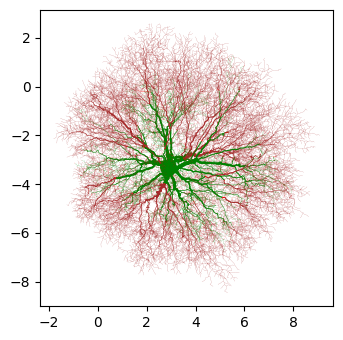

C:\Users\wisch\AppData\Local\Temp\ipykernel_18508\1463736946.py:1083: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  hull, edge_points = concave_hull(DivideCentroids, alpha)


<class 'shapely.geometry.multipolygon.MultiPolygon'>


C:\Users\wisch\AppData\Local\Temp\ipykernel_18508\1463736946.py:1093: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  tot_hull, edge_points = concave_hull(endNodes, alpha)


In [312]:
#create cyls
# cyls_test_xz = []
# cyls = []
fileNames = read_file_names()
idx = 0
# # files_run = [
# # 'Secrest32-14_000000.csv'
# # ,'Secrest32-01_000000.csv'
# # ,'Secrest31-05_000000.csv'
# # ,'Secrest29-25_000000.csv'
# # ,'Secrest27-05_000000.csv'
# # ,'Secrest18-13_000000.csv'
# # ,'Secrest18-13_000000.csv'
# # ,'Secrest11-27_000000.csv'
# # ,'Secrest10-02_000000.csv'
# # ,'Secrest14-09_000000.csv'
# # ,'Secrest10-08_000000.csv'
# # ,'Secrest32-03_000000.csv'
# # ,'Secrest32-06_000000.csv'
# # ,'Secrest08-24c_000000.csv'
# # ,'Secrest07-32_000000.csv'
# # ,'Secrest02-26_000000.csv'
# # ]
for idx,f in enumerate(fileNames):
    for proj in ['XY']:
        if idx!=-1:
            print(f)
            c = CylinderCollection(f)

            cyls.append(c)
            cyls[idx].readCsv(projection =proj)
            cyls[idx].projectCylinders()
            cyls[idx].createGraph()
            cyls[idx].findFlows()
            cyls[idx].aggregateDrips()
            cyls[idx].highlightDrips()
            cyls[idx].findWatershedBoundary() 
            


